# MACD Trading Model

Import packages

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas_datareader as pdr
from datetime import date

from trading_tools import MACD_Model

In [2]:
sns.set_context("notebook")

## 1. Backtesting

For my model I picked Erste Bank AG stock to trade, as it is quite volatile and has interesting patterns in it. I didn't pick any ETFs, because I wanted to test how mmy model would handle risky asset with volatile periods. Austrian market is quite illiquid as well, so it is an interesting case to study by using such a model. 

In [3]:
stock = yf.download('EBS.VI',start = "1980-01-01",end = "2025-01-01")

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Erste Bank AG')

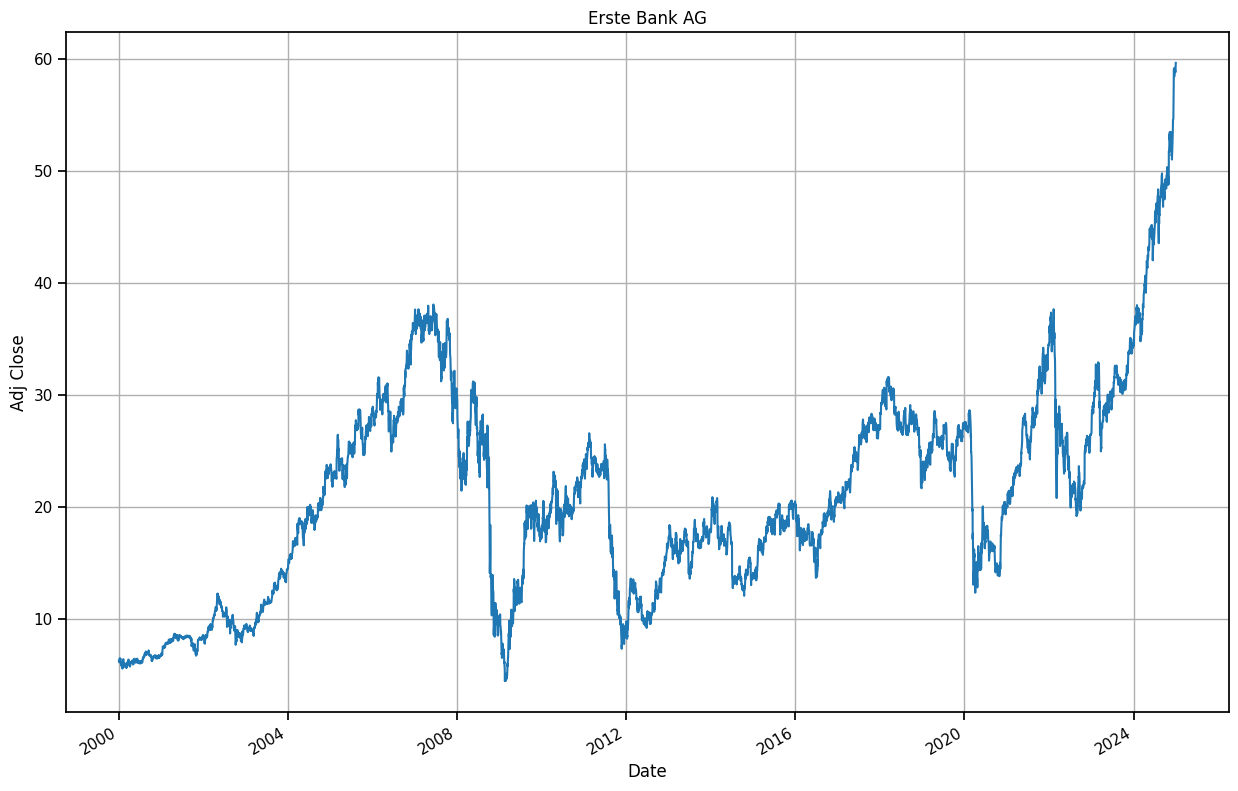

In [4]:
plt.figure(figsize=(15,10))
stock['Adj Close'].plot()
plt.grid()
plt.ylabel('Adj Close')
plt.title('Erste Bank AG')

Let's analyse the strategy: we have two thresholds $MA_l$ and $MA_s$ for length of moving average window that would be adjustable and tunable later in `MACD_Model`

<Figure size 1500x1000 with 0 Axes>

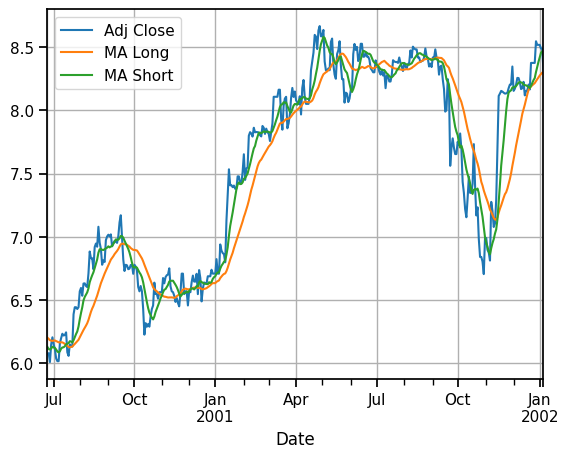

In [5]:
plt.figure(figsize=(15,10))
stock['MA Long'] = stock['Adj Close'].rolling(window=26).mean()
stock['MA Short'] = stock['Adj Close'].rolling(window=9).mean()
stock.dropna(inplace=True)
stock.iloc[100:500][['Adj Close','MA Long', 'MA Short']].plot()
plt.grid()

<Figure size 1500x1000 with 0 Axes>

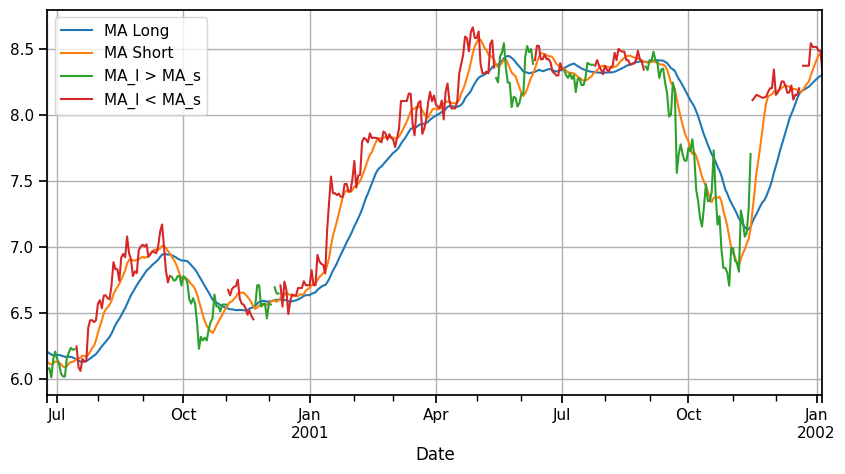

In [6]:
plt.figure(figsize=(15,10))
stock['MA_l > MA_s'] = np.where(stock['MA Long'] > stock['MA Short'], stock['Adj Close'], None)
stock['MA_l < MA_s'] = np.where(stock['MA Long'] < stock['MA Short'], stock['Adj Close'], None)
stock.iloc[100:500][['MA Long', 'MA Short', 'MA_l > MA_s', 'MA_l < MA_s']].plot(figsize=(10,5))
stock.drop(['MA_l < MA_s','MA_l > MA_s'],axis=1,inplace=True)
plt.grid()

Use developed model and train the hyperparameters $MA_l, MA_s$

In [ ]:
model = MACD_Model(stock)
# optimized_params = model.tune('2000','2012')

In [8]:
# PARAMS = np.round(optimized_params)[0]
PARAMS = [80,50]

In [9]:
model = MACD_Model(stock)
model.set_params(PARAMS)
simulation_results,metrics = model.run_simulation('2014','2024')

Analyse the metrics(ann. return, ann. volatility, Sharpe ratio(composed from ann.ret. and ann.vol.)) on the test interval 2014-2024. Returns are quite low, but later I show that volatility is actually lower than if Buy and Hold strategy on this stock would be used(even though I use parameters for bigger Sharpe ratio in this and later examples)

~4% is an actually good result, keeping in mind we are dealing with Austrian market(average inflation rate in this period is <a href="https://tradingeconomics.com/austria/inflation-cpi">lower than 4%</a>) 

Buy and Hold: volatility is higher than MACD model's volatility and Sharpe ratio is higher. 

[*********************100%***********************]  1 of 1 completed


                      Returns        Volatility         Sharpe Ratio
Model metrics: 0.057886348323707315 0.18121596920624602 0.04351905827202061
Buy and Hold: 0.06964334253521898 0.34434687916309636 0.20224763675651936


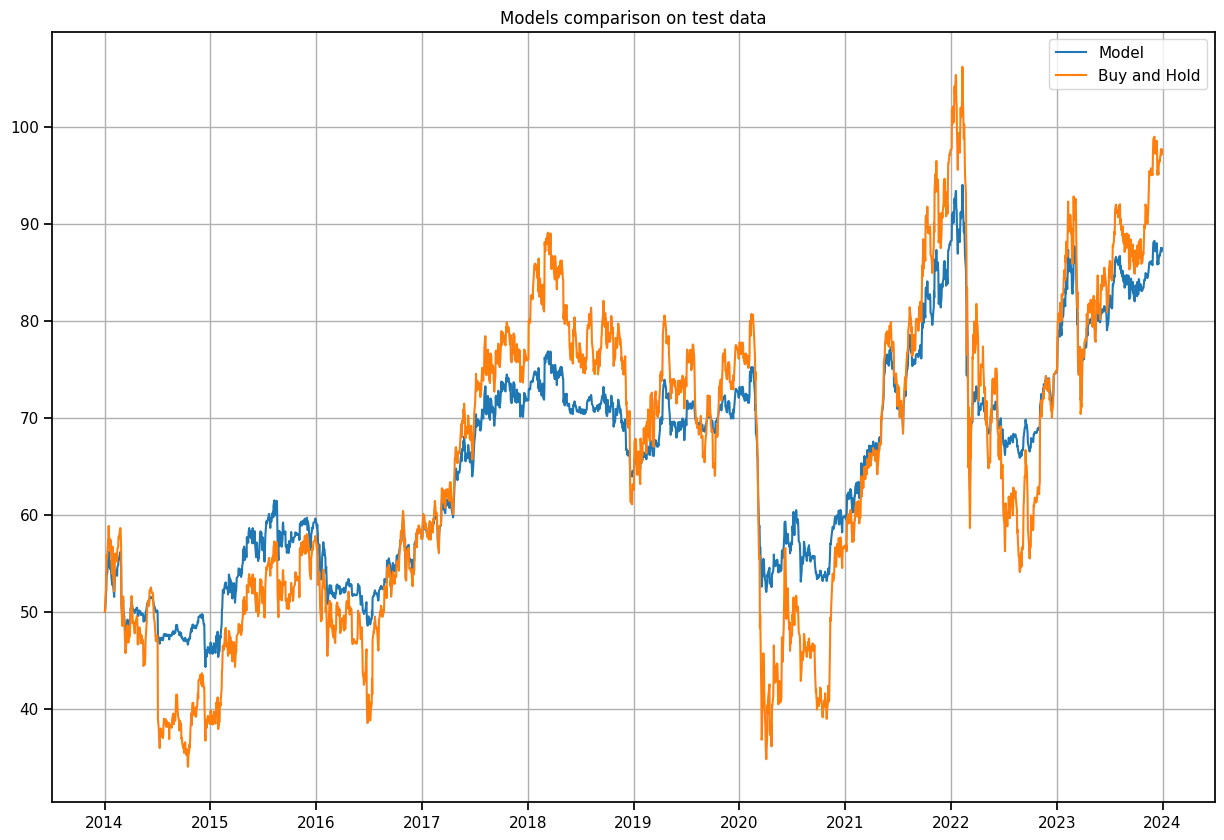

In [10]:
plt.figure(figsize=(15,10))
plt.plot(simulation_results['Capital'],label='Model')

ebs_14_24 = yf.download('EBS.VI',start = "2014-01-01",end = "2024-01-01")
ret = ebs_14_24['Adj Close'].pct_change().dropna()

years = ebs_14_24.shape[0]/252
totret = (ret + 1).prod() - 1
annret = (1 + totret) ** (1 / years) - 1

vol = ret.std()
annvol = vol * np.sqrt(252)

rf = 0 # Risk free rate for Buy and Hold, use 0 for simplicity
sr =  (annret - rf) / annvol 

import yaml 
with open('config.yaml') as file: 
    config = yaml.safe_load(file)


plt.plot(ebs_14_24['Adj Close']/ebs_14_24['Adj Close'].iloc[0]*config['initial_capital'],label='Buy and Hold')
plt.grid()
plt.title('Models comparison on test data')
plt.legend()
print('                      Returns        Volatility         Sharpe Ratio')
print('Model metrics:',metrics.ret,metrics.vol,metrics.sr)
print('Buy and Hold:',annret,annvol,sr)

We get a trade-off in volatility as it is lower than benchmark strat., because the model handles big jumps in stock better, although the returns are lower 

Let's see what happens on train data: 

[*********************100%***********************]  1 of 1 completed


Model metrics: 0.13448879216163934 0.20273581522759163 0.4167432975115524
Buy and Hold: 0.033970228165427274 0.4343313923682894 0.07821269372263649


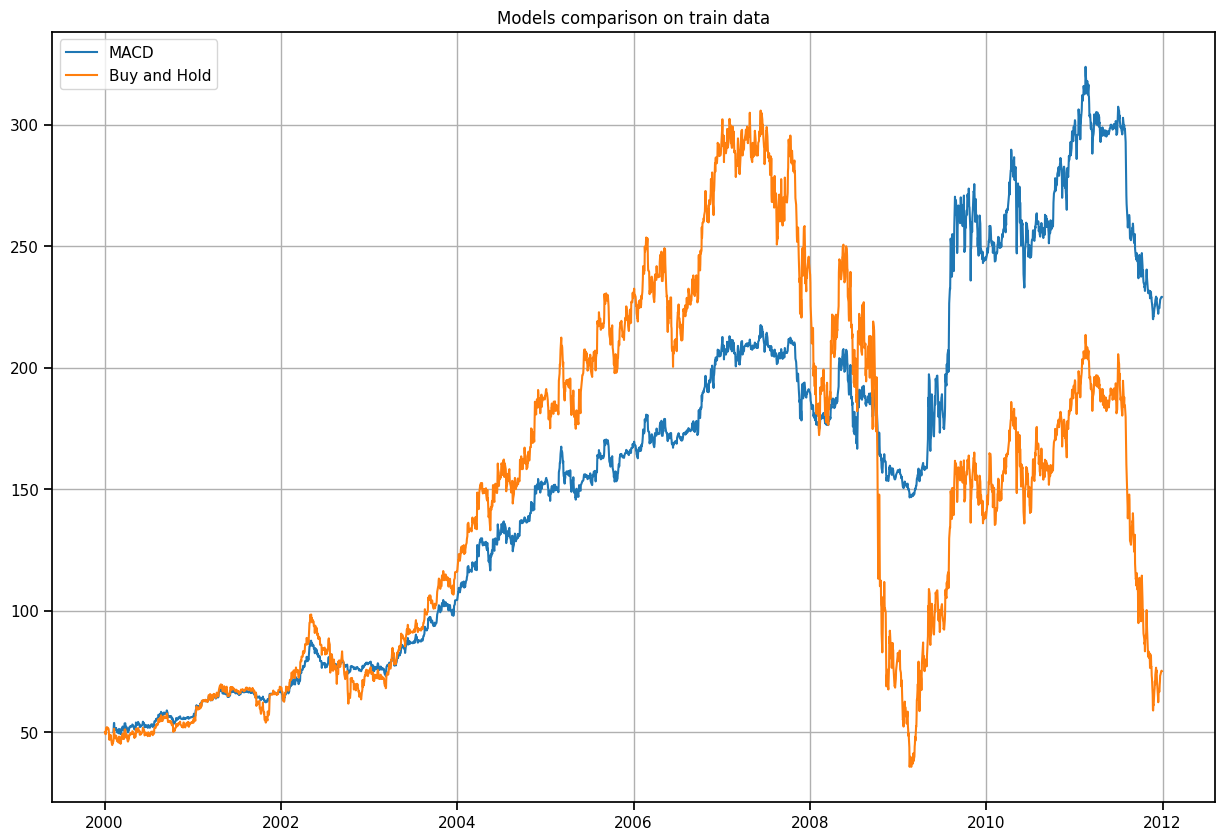

In [11]:
plt.figure(figsize=(15,10))
model = MACD_Model(stock)
model.set_params(PARAMS)
simulation_results,metrics = model.run_simulation('2000','2012')
plt.plot(simulation_results['Capital'],label='MACD')

ebs_14_24 = yf.download('EBS.VI',start = "2000-01-01",end = "2012-01-01")
ret = ebs_14_24['Adj Close'].pct_change().dropna()

years = ebs_14_24.shape[0]/252
totret = (ret + 1).prod() - 1
annret = (1 + totret) ** (1 / years) - 1

vol = ret.std()
annvol = vol * np.sqrt(252)

rf = 0 # Risk free rate for Buy and Hold, use 0 for simplicity
sr =  (annret - rf) / annvol 

import yaml 
with open('config.yaml') as file: 
    config = yaml.safe_load(file)

plt.plot(ebs_14_24['Adj Close']/ebs_14_24['Adj Close'].iloc[0]*config['initial_capital'],label='Buy and Hold')
plt.grid()
plt.title('Models comparison on train data')
plt.legend()
print('Model metrics:',metrics.ret,metrics.vol,metrics.sr)
print('Buy and Hold:',annret,annvol,sr)

All metrics of our model are much more better. This however was used as an example and shouldn't showcase peformance of a real model, as the tuning of hyperparameters might be overfitted

Performance on the entire timeframe: 

(0.10186378694167075, 0.19576938707771618, 0.2649228651928197)

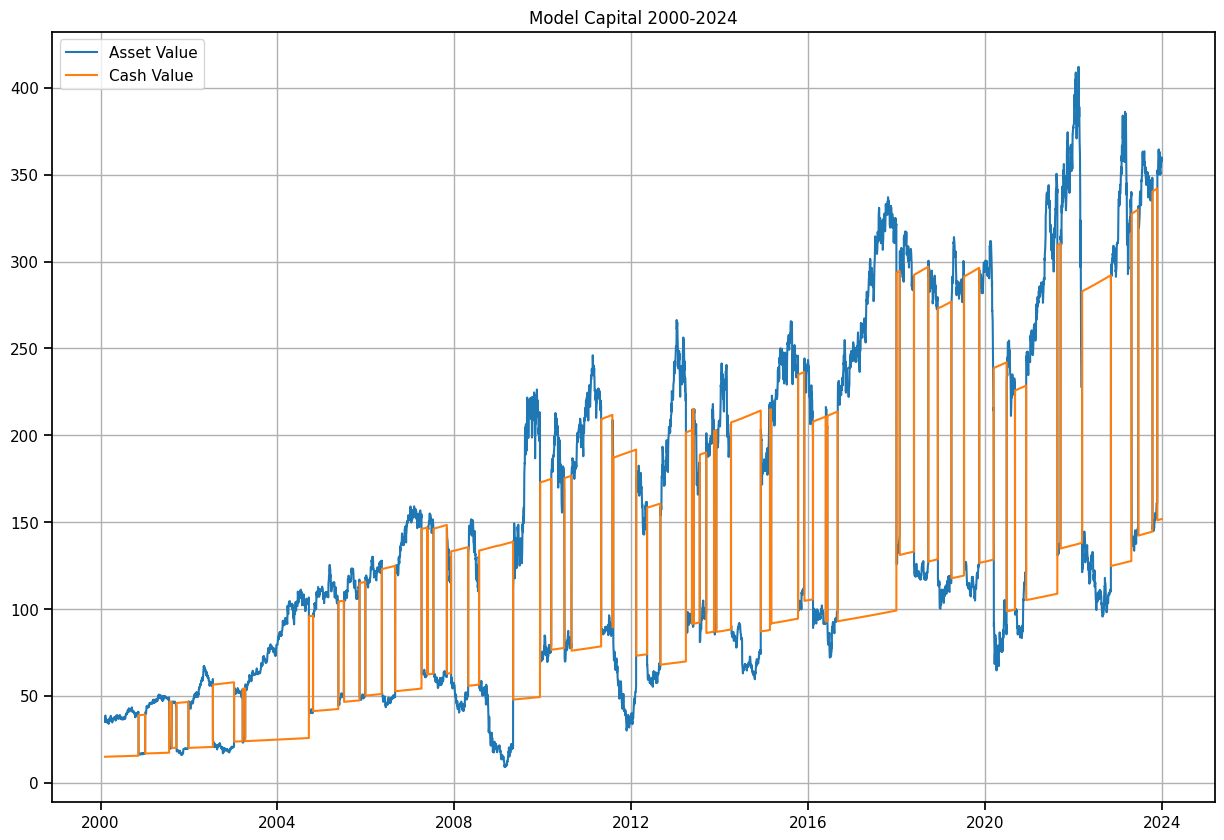

In [12]:
plt.figure(figsize=(15,10))
model = MACD_Model(stock)
model.set_params(PARAMS)
simulation_results,metrics = model.run_simulation('2000','2024')
plt.plot(simulation_results['Asset'],label='Asset Value')
plt.plot(simulation_results['Cash'],label='Cash Value')
plt.legend()
plt.title('Model Capital 2000-2024')
plt.grid()
metrics.ret,metrics.vol,metrics.sr

Here are cash and asset parts of whole capital plotted as well 

## 2. Monte Carlo simulations

Formula for future returns derived from Brownian motion equations: $$X_{t+\Delta t} = X_t e^{(\mu-\frac{\sigma^2}{2})\Delta t+\sigma \varepsilon _t\sqrt\Delta t}$$

In [13]:
def simulate_MC(x,mu,sigma,t=252,dt=1): 
    X_t = x
    drift = mu*dt 
    eps = np.random.normal(mu,sigma,t)
    res = []
    for i in range(t):
        diff = sigma*eps[i]*np.sqrt(dt)
        X_t_dt = X_t*np.exp(drift+diff-sigma**2/2)
        res.append(X_t_dt)
        X_t = X_t_dt
    return res 

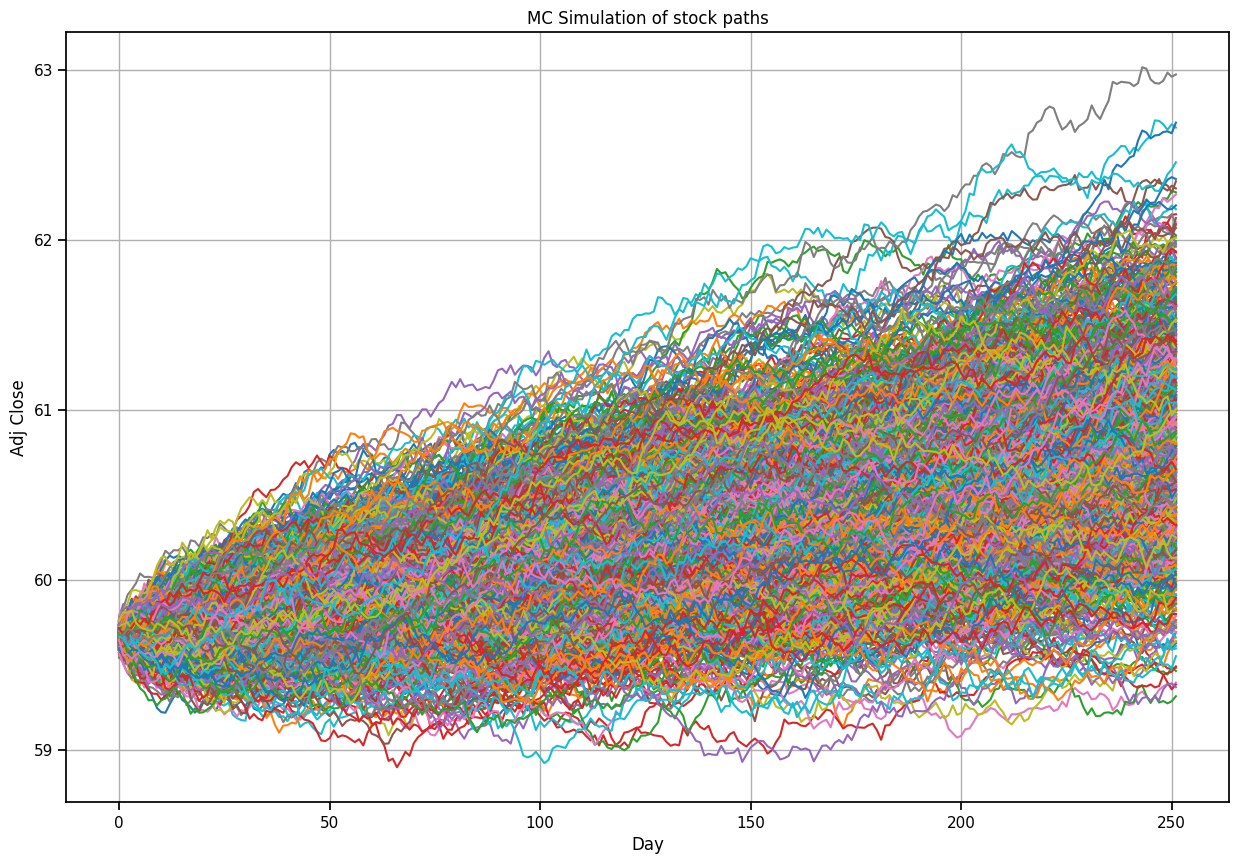

In [14]:
plt.figure(figsize=(15,10))
mu = ((stock['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
sigma = stock['Adj Close'].pct_change().dropna().std()
x = stock.iloc[-1]['Adj Close']

for _ in range(1000):
    plt.plot(simulate_MC(x,mu,sigma))
plt.title('MC Simulation of stock paths')
plt.ylabel('Adj Close')
plt.xlabel('Day')
plt.grid()

One more time, but with previous adj. close prices(simulated paths are not accurate, but still can be used for our analysis)

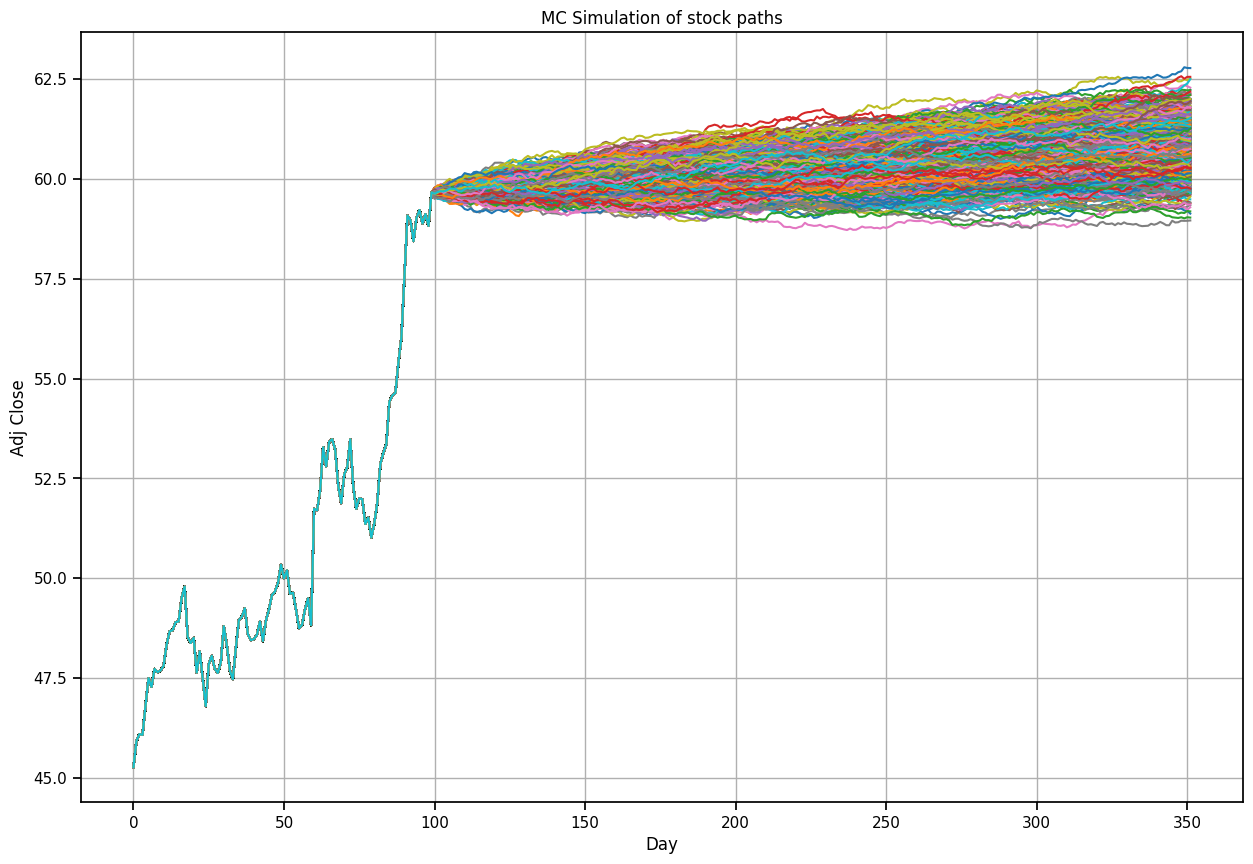

In [15]:
plt.figure(figsize=(15,10))
stock_pred=stock.iloc[:,-100:].copy()
mu = ((stock['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
sigma = stock['Adj Close'].pct_change().dropna().std()
x = stock.iloc[-1]['Adj Close']

for _ in range(1000):
    stock_pred=stock.iloc[-100:]['Adj Close'].copy()
    stock_pred = pd.concat([stock_pred,pd.Series(simulate_MC(x,mu,sigma))])
    stock_pred.reset_index(drop=True).plot()

plt.title('MC Simulation of stock paths')
plt.ylabel('Adj Close')
plt.xlabel('Day')
plt.grid()

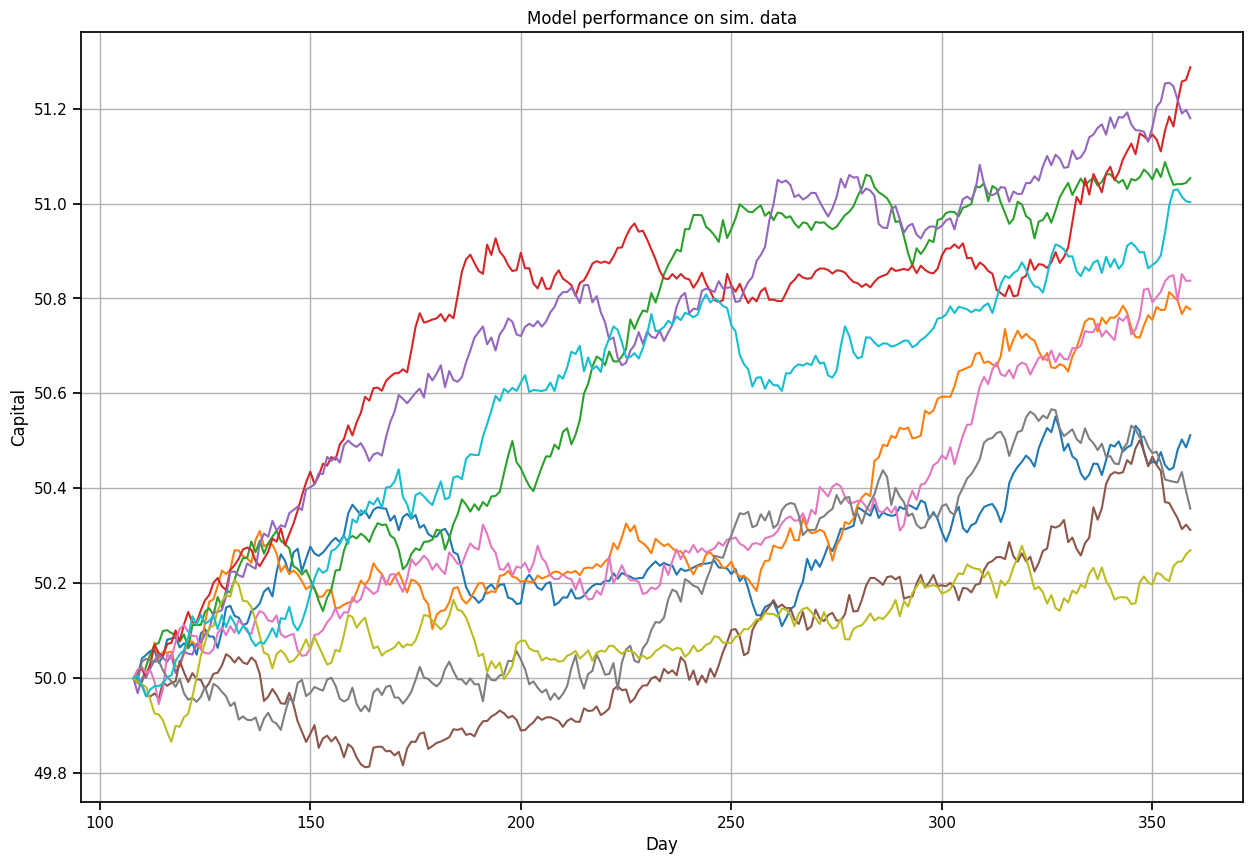

In [22]:
plt.figure(figsize=(15,10))
mu = ((stock['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
sigma = stock['Adj Close'].pct_change().dropna().std()
x = stock.iloc[-1]['Adj Close']

def var_historic(data: pd.DataFrame, level = 99):
    return -np.percentile(data, (100 - level))
def cvar_historic(data: pd.DataFrame, level = 99):
    is_beyond = data <= -var_historic(data, level = level)
    return -data[is_beyond].mean()

returns = []
var_cvar = []

for _ in range(10):
    gen_df = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma)})

    df = pd.concat([stock.reset_index(), gen_df])[-360:].reset_index()[['Adj Close']]
    df['MA Long'] = df['Adj Close'].rolling(window=int(PARAMS[0])).mean()
    df['MA Short'] = df['Adj Close'].rolling(window=int(PARAMS[1])).mean()
    df = df.iloc[-252:]
    
    model_mc = MACD_Model()
    model_mc.ir_const = True
    sim,_ = model_mc.run_simulation(data=df)
    rets = sim['Capital'].pct_change().dropna()
    var_cvar.append([var_historic(rets),cvar_historic(rets)])
    returns.append(-model_mc.calculate_metrics('return'))
    sim['Capital'].plot()
plt.title('Model performance on sim. data')
plt.ylabel('Capital')
plt.xlabel('Day')
plt.grid()

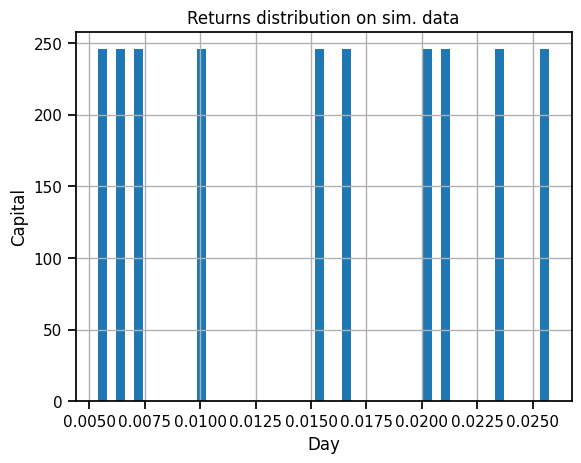

In [23]:
plt.hist(returns,50,density=1)
plt.title('Returns distribution on sim. data')
plt.ylabel('Capital')
plt.xlabel('Day')
plt.grid()

From the distribution and model performance(see graph) one can derive that model trades successfully on predicted data. 

In [24]:
print('VaR                    CVaR')
print(tuple(np.mean(var_cvar,axis=0)))

VaR                    CVaR
(0.0008299076271655826, 0.000942938548790088)


## 3. FED Scenario Analysis

In [25]:
today = date.today()

In [26]:
def transform_returns(data,n_cols):
    '''
    Help function to transform data into annualized returns
    '''
    n_rows = int(np.ceil(len(data) / n_cols))
    total_elements = n_rows * n_cols
    padded_vector = np.pad(data, (0, total_elements - len(data)), 'constant')
    r = padded_vector.reshape(n_rows, n_cols).T
    ret = np.prod(r+1,axis=0) ** (1/252) -1
    return ret 

Here I use German market indicator DAX, as it is as close as I can get to Austrian without dealing with missing values of eariler periods

In [27]:
dax = yf.download('DAX',start = '2015-01-01',end = today)
dax['Adj Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


Date
2015-01-05   -0.049039
2015-01-06    0.000000
2015-01-07    0.000000
2015-01-08    0.028135
2015-01-09    0.000000
                ...   
2024-12-27   -0.012603
2024-12-30   -0.004435
2024-12-31   -0.003916
2025-01-02   -0.005672
2025-01-03    0.002717
Name: Adj Close, Length: 2517, dtype: float64

In [28]:
dax[dax.index >= '2024'].shape[0] # note that 2024 is not over :-(, use this number instead of 252 to be more precise for ann.ret. calculation

254

In [29]:
dax_r = np.array(dax['Adj Close'].pct_change().dropna())
ret_m = transform_returns(dax_r,252)

In [30]:
ebs = yf.download('EBS.VI',start = "2015-01-01",end = today)
ebs_r = np.array(ebs['Adj Close'].pct_change().dropna())

ret = transform_returns(ebs_r,252)

[*********************100%***********************]  1 of 1 completed


In [31]:
rf = pd.DataFrame(pdr.DataReader('FEDFUNDS', 'fred',start = "2015-01-01",end = today) / 100)
rf

FEDFUNDS
DATE                
2015-01-01    0.0011
2015-02-01    0.0011
2015-03-01    0.0011
2015-04-01    0.0012
2015-05-01    0.0012
...              ...
2024-08-01    0.0533
2024-09-01    0.0513
2024-10-01    0.0483
2024-11-01    0.0464
2024-12-01    0.0448

[120 rows x 1 columns]

In [32]:
rf_r = transform_returns(rf.FEDFUNDS,12)

In [33]:
adj_a_r = ret - rf_r
adj_m_r = ret_m - rf_r

Regress adj.asset returns on adj. market returns using least squares(lin.regressor can be used as well, but in this case with 10x1 data let's use the simpler one as one is based on another)

In [34]:
b, residuals, rank, s = np.linalg.lstsq(np.atleast_2d(adj_m_r).T, np.atleast_2d(adj_a_r).T, rcond=None)

In [35]:
BETA = b[0,0]
print('Beta for CAPM')
print(BETA)

Beta for CAPM
0.6940922752630817


In [36]:
r_m_last = ret_m[-1]
r_f_last = rf.iloc[-1].FEDFUNDS

In [37]:
def get_rf(bp,p,n_path): 
    v = np.random.choice([1, 0], size=(n_path,2), p=[p, 1-p])
    dist = v * bp * 1e-4 
    return dist + (r_f_last+1)**(1/252) -1 
get_rf(25,0.6,1000) 

array([[0.00267393, 0.00267393],
       [0.00267393, 0.00017393],
       [0.00267393, 0.00267393],
       ...,
       [0.00017393, 0.00267393],
       [0.00017393, 0.00017393],
       [0.00267393, 0.00267393]])

In [47]:
def fed_sim(bp,p,n_path): 
    '''
    Function for simulation of FED dropping/raising interest rates
    '''
    rf = get_rf(bp,p,n_path)

    mu = ((ebs['Adj Close'].pct_change().dropna()+1).prod())**(1/ebs.shape[0])-1
    sigma = ebs['Adj Close'].pct_change().dropna().std()
    capital = []
    asset = []
    for i in range(n_path):

        m = rf[i] + BETA * ((r_m_last+1)**(1/252)-1-rf[i])

        x = ebs.iloc[-1]['Adj Close']
        df1 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
        
        x = df1['Adj Close'].iloc[-1]

        x += x*m[0]

        df2 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
        x = df2['Adj Close'].iloc[-1]

        x += x*m[1]

        df3 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})


        gen_df = pd.concat([ebs[-200:],df1,df2,df3]).reset_index()
        gen_df['MA Long'] = gen_df['Adj Close'].rolling(window=int(PARAMS[0])).mean()
        gen_df['MA Short'] = gen_df['Adj Close'].rolling(window=int(PARAMS[1])).mean()
        gen_df = gen_df[200:].reset_index(drop=True)

        asset.append(list(gen_df['Adj Close']))

        model_mc = MACD_Model()
        model_mc.ir_const = True 
        model_mc.ir = (r_f_last+1)**(1/252) - 1 

        
        sim1,_ = model_mc.run_simulation(data=gen_df[:84])

        model_mc.ir = rf[i][0]

        sim2,_ = model_mc.run_simulation(data=gen_df[84:168])
        model_mc.ir = rf[i][1]

        sim3,_ = model_mc.run_simulation(data=gen_df[168:])
        sim_df = pd.concat([sim1,sim2,sim3]).reset_index(drop=True)

        capital.append(sim_df['Capital'])
        plt.plot(sim_df['Capital']) 
    return np.array(capital),np.array(asset)

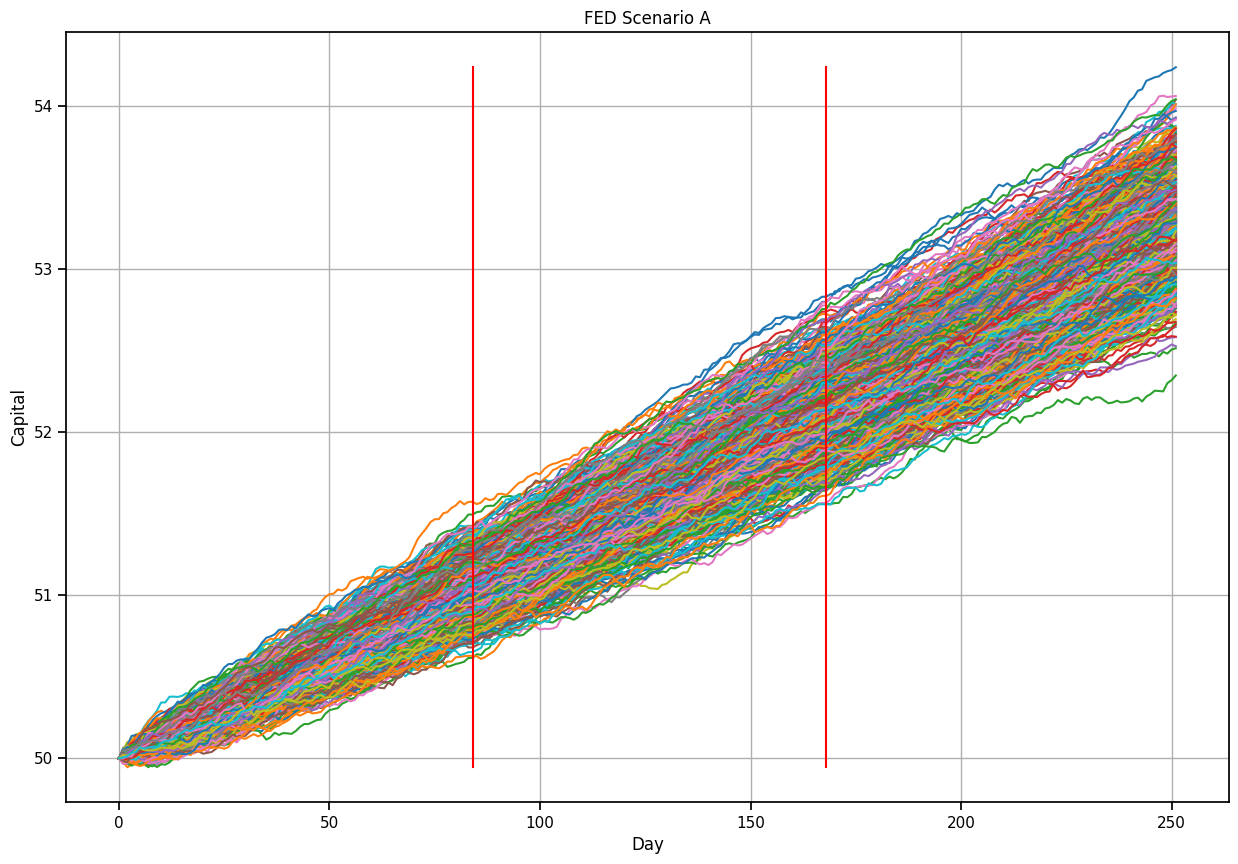

In [48]:
plt.figure(figsize=(15,10))
cap,_ = fed_sim(25,0.6,1000)
plt.plot([84,84],[cap.min(),cap.max()],c='r')
plt.plot([168,168],[cap.min(),cap.max()],c='r')
plt.title('FED Scenario A')
plt.ylabel('Capital')
plt.xlabel('Day')
plt.grid()

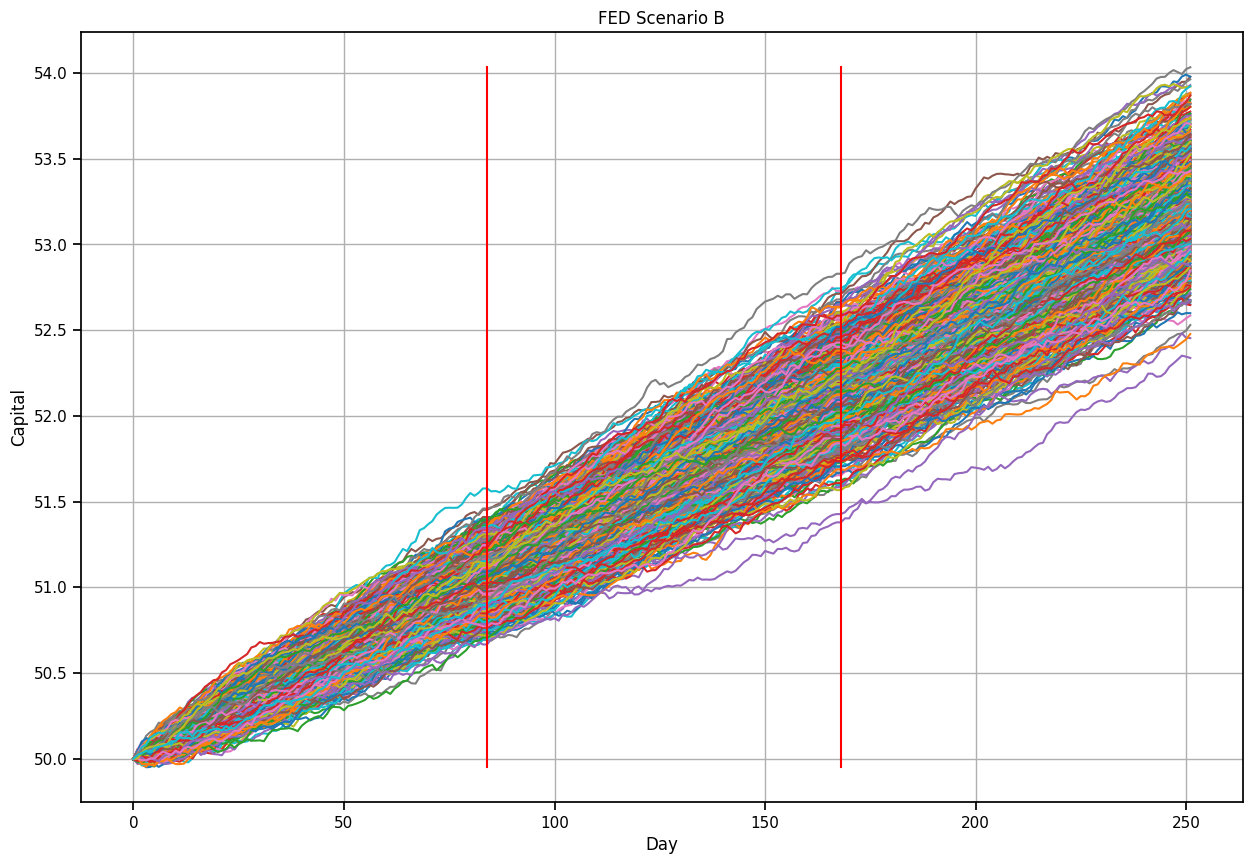

In [40]:
plt.figure(figsize=(15,10))
cap,asset = fed_sim(-25,0.7,1000)
plt.plot([84,84],[cap.min(),cap.max()],c='r')
plt.plot([168,168],[cap.min(),cap.max()],c='r')
plt.title('FED Scenario B')
plt.ylabel('Capital')
plt.xlabel('Day')
plt.grid()

<small>I left this commented code for history :-)</small>

In [35]:
# def fed_sim(bp,p,n_path): 
#     dist = np.random.choice([1, 0], size=(n_path,2), p=[p, 1-p])

#     mu = ((stock['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
#     sigma = stock['Adj Close'].pct_change().dropna().std()
#     results = []
#     for i in range(n_path):
        
#         x = stock.iloc[-1]['Adj Close']
#         df1 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
#         x = df1['Adj Close'].iloc[-1]
#         dx = bp * x * dist[i][0] * 1e-4
#         x += dx
#         df2 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
#         x = df2['Adj Close'].iloc[-1]
#         dx = bp * x * dist[i][0] * 1e-4
#         x += dx
#         df3 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})

#         gen_df = pd.concat([df1,df2,df3]).reset_index()
#         results.append(list(gen_df['Adj Close']))
#         gen_df['Adj Close'].plot()

#     result = np.array(results)

#     plt.plot([84,84],[result.min(),result.max()],c='r')
#     plt.plot([168,168],[result.min(),result.max()],c='r')

#     return result

In [36]:
# def fed_sim_model(bp,p,n_path): 
#     dist = np.random.choice([1, 0], size=(n_path,2), p=[p, 1-p])

#     mu = ((stock['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
#     sigma = stock['Adj Close'].pct_change().dropna().std()
#     for i in range(n_path):
        
#         x = stock.iloc[-1]['Adj Close']
#         df1 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
#         x = df1['Adj Close'].iloc[-1]
#         dx = bp * x * dist[i][0] * 1e-4
#         x += dx
#         df2 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
#         x = df2['Adj Close'].iloc[-1]
#         dx = bp * x * dist[i][0] * 1e-4
#         x += dx
#         df3 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})

#         gen_df = pd.concat([df1,df2,df3]).reset_index()

#         model_mc = MACD_Model(gen_df)
#         model_mc.set_params([200,5])
#         sim,_,_ = model_mc.run_simulation(0,-1)
#         sim['Capital'].plot()

#     plt.plot([84,84],[9.9e5,10.5e5])
#     plt.plot([168,168],[9.9e5,10.5e5])